In [6]:
import numpy as np
import matplotlib.pyplot as plt
from qibo.hamiltonians import SymbolicHamiltonian
from qibo import symbols
from scipy.linalg import expm
from qibo import hamiltonians, set_backend
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketScheduling, DoubleBracketIteration, DoubleBracketCostFunction

from copy import deepcopy
# Hamiltonian
set_backend("numpy")

[Qibo 0.2.7|INFO|2024-05-21 13:57:42]: Using numpy backend on /CPU:0


In [66]:
def h(nqubits, alpha, beta):
    """
    $H_nn = \sum_{i=0}^{n-1}+\alpha*\sum_{i=0}^{n-2} Z_i Z_{i+2} + \beta*\sum_{i=0}^{n} X_i$
    """
    op_list = [symbols.Z(i)*symbols.Z(i+1) for i in range(nqubits-1)]
    symbolHam = 0
    for op in op_list:
        symbolHam += op
        
    op_list = [symbols.Z(i)*symbols.Z(i+2) for i in range(nqubits-2)]
    for op in op_list:
        symbolHam += alpha*op
    op_list = [symbols.X(i) for i in range(nqubits)]
    for op in op_list:
        symbolHam += beta*op
    h = SymbolicHamiltonian(symbolHam, nqubits=nqubits)
    h = h.dense.matrix
    return h

def x_inv_odd(nqubits):
    """
    returns product of X_i for odd i
    $X_{odd} = \prod_{i=0}^{n-1} X_{2i+1}$
    """
    op_list = [symbols.X(i) for i in range(nqubits) if i%2==1]
    symbolHam = 1
    for op in op_list:
        symbolHam *= op
    h = SymbolicHamiltonian(symbolHam, nqubits=nqubits)
    h = h.dense.matrix
    return h

def z_product(nqubits):

    op_list = [symbols.Z(i) for i in range(nqubits)]
    symbolHam = 1
    for op in op_list:
        symbolHam *= op
    h = SymbolicHamiltonian(symbolHam, nqubits=nqubits)
    h = h.dense.matrix
    return h

In [67]:
alpha = np.linspace(0,1,50)
beta = np.linspace(0,1,50)
nqubits = 5
x = x_inv_odd(nqubits)
inversion_measure = np.empty((len(alpha),len(beta)))
for a in range(len(alpha)):
    for b in range(len(beta)):
        ham = h(nqubits,alpha[a],beta[b])
        inversion_measure[a,b] = np.linalg.norm(ham+x@ham@x)

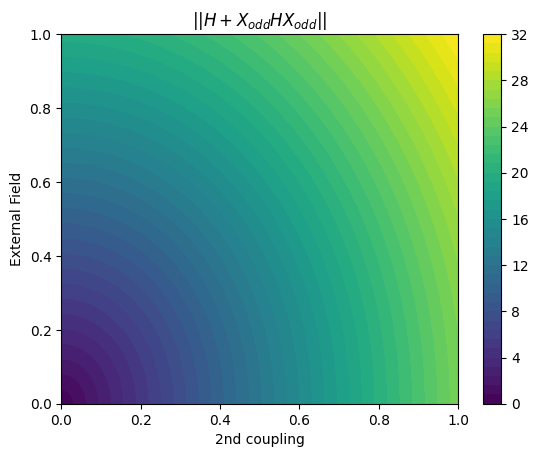

In [68]:
mesh_alpha, mesh_beta = np.meshgrid(alpha,beta)
plt.contourf(mesh_alpha,mesh_beta,inversion_measure,levels=50)
plt.title(r"$||H+X_{odd} H X_{odd}||$")
plt.xlabel(r"2nd coupling")
plt.ylabel(r"External Field")
plt.colorbar()
plt.show()


In [69]:
def imperfect_gci(H,D,s,inversion,order):
    U = expm(1j*np.sqrt(s/order)*D)@expm(1j*np.sqrt(s/order)*H)@expm(-1j*np.sqrt(s/order)*D)
    U_order = np.linalg.matrix_power(U,order) 
    U_dag = expm(-1j*np.sqrt(s/order)*D)@inversion@expm(1j*np.sqrt(s/order)*H)@inversion@expm(1j*np.sqrt(s/order)*D)
    U_dag_order = np.linalg.matrix_power(U_dag,order)

    return U_dag_order@H@U_order


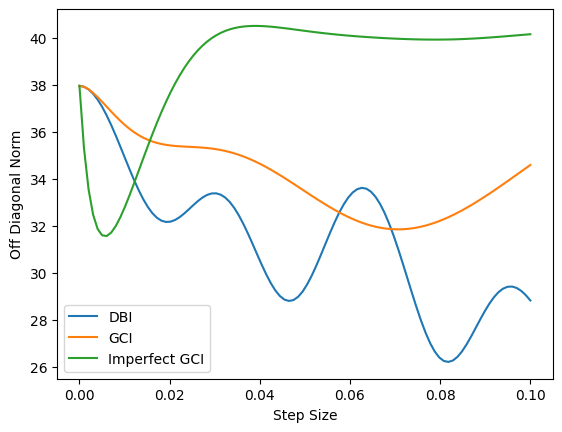

In [73]:
H = h(nqubits,1,3)
d = np.diag(np.linspace(0,2**nqubits,2**nqubits))
hamiltonian = hamiltonians.Hamiltonian(nqubits, H)
dbi = DoubleBracketIteration(deepcopy(hamiltonian),mode=DoubleBracketGeneratorType.single_commutator,cost=DoubleBracketCostFunction.least_squares)
s = np.linspace(0,0.1,100)
inversion = x_inv_odd(nqubits)
off_diagonal_norm = np.empty((len(s),3))
for step in range(len(s)):
    dbi_eval = deepcopy(dbi)
    h_gci = imperfect_gci(H,d,s[step],inversion,1)
    off_diagonal_norm[step,0] = np.linalg.norm(h_gci-np.diag(np.diag(h_gci)))
    dbi_eval(s[step],d=d)
    off_diagonal_norm[step,1] = dbi_eval.off_diagonal_norm
    dbi_eval = deepcopy(dbi)
    dbi_eval.mode = DoubleBracketGeneratorType.group_commutator
    order = 1
    for _ in range(order):
        dbi_eval(s[step]/order,d=d)
    off_diagonal_norm[step,2] = dbi_eval.off_diagonal_norm


plt.figure()
plt.plot(s,off_diagonal_norm[:,1],label="DBI")
plt.plot(s,off_diagonal_norm[:,2],label="GCI")
plt.plot(s,off_diagonal_norm[:,0],label="Imperfect GCI")
plt.xlabel(r"Step Size")
plt.ylabel(r"Off Diagonal Norm")
plt.legend()
